In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
import imageio

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## 1. load temperature data and add time features

In [2]:
# load temperature data from Tempelhofer Feld, Berlin, Germany in pandas(downloaded from www.ecad.eu)
folder_Data = "../../data/ECA_blended_custom(6)/"
with open(file=folder_Data + "TG_STAID002759.txt", mode = 'r') as file:
    df_raw = pd.read_csv(file, sep=',', header='infer', skiprows=19)

In [3]:
# strip leading whitespaces in headers
df_raw.columns = ['SOUID', 'DATE', 'TG', 'Q_TG']
# divide the temperature by 10
df_raw['TG'] = df_raw['TG'].apply(lambda x: x / 10)
# add month, quarter and year column
df_raw['DATETIME'] = pd.to_datetime(df_raw['DATE'],format="%Y%m%d")
df_raw['MONTH'] = df_raw['DATETIME'].dt.month
df_raw['QUARTER'] = df_raw['DATETIME'].dt.quarter
df_raw['YEAR'] = df_raw['DATETIME'].dt.year
# make the date as an index and drop it then
df_raw.reset_index()
df_raw.head(5)

,SOUID,DATE,TG,Q_TG,DATETIME,MONTH,QUARTER,YEAR
0,127488,18760101,2.2,0,1876-01-01,1,1,1876
1,127488,18760102,2.5,0,1876-01-02,1,1,1876
2,127488,18760103,0.3,0,1876-01-03,1,1,1876
3,127488,18760104,-5.8,0,1876-01-04,1,1,1876
4,127488,18760105,-9.8,0,1876-01-05,1,1,1876


## 2. Examine and edit data

In [4]:
# check for missing values
df_raw.isna().sum()

SOUID       0
DATE        0
TG          0
Q_TG        0
DATETIME    0
MONTH       0
QUARTER     0
YEAR        0
dtype: int64

In [5]:
# val-train-split of the data (last year will be validation data)
df_train = df_raw[:-365]
df_val = df_raw[-365:]

### 2.1 outlier treatment

<AxesSubplot:xlabel='DATETIME', ylabel='TG'>

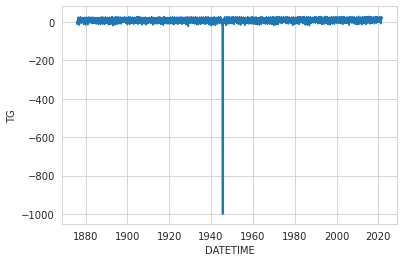

In [6]:
# outlier detection
sns.lineplot(x = df_train['DATETIME'], y = df_train['TG'])

In [46]:
# checking the distributions to decide an outlier threshold
df_train['TG'].describe()


count    53173.000000
mean         5.691328
std         61.514404
min       -999.900000
25%          3.300000
50%          9.400000
75%         15.700000
max         30.500000
Name: TG, dtype: float64

In [10]:
# find all timesteps smaller than mean + std (std here heavily biased by the outliers)
df_train[['TG', 'DATETIME','Q_TG']].loc[df_train['TG'] < (5.691328 - 61.51)]

,TG,DATETIME,Q_TG
25316,-999.9,1945-04-25,9
25317,-999.9,1945-04-26,9
25318,-999.9,1945-04-27,9
25319,-999.9,1945-04-28,9
25320,-999.9,1945-04-29,9
...,...,...,...
25506,-999.9,1945-11-01,9
25507,-999.9,1945-11-02,9
25508,-999.9,1945-11-03,9
25509,-999.9,1945-11-04,9


In [11]:
# creating the masks for filling the missing values: 
# - all missing values (labelled with Q_TG == 9) have a value of 999.9 degrees
# - fill the data with the average of the day of the previous and next year 
missing_value_mask = (df_train['Q_TG'] == 9)
next_year_mask = (df_train.loc[df_train['Q_TG'] == 9].index + 365)
previous_year_mask = (df_train.loc[df_train['Q_TG'] == 9].index - 365)

In [12]:
# fill the data with the average of the day of the previous and next year 
run_code = True
if run_code:
    df_train['TG'].loc[missing_value_mask] = (df_train['TG'].iloc[next_year_mask].values + df_train['TG'].iloc[previous_year_mask].values) / 2

/tmp/ipykernel_17356/1117582482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TG'].loc[missing_value_mask] = (df_train['TG'].iloc[next_year_mask].values + df_train['TG'].iloc[previous_year_mask].values) / 2


In [13]:
# check now the filled year 1945
df_train['TG'].loc[df_train['YEAR'] == 1945].describe()

count    365.000000
mean       9.657123
std        7.601662
min       -9.500000
25%        4.200000
50%        9.800000
75%       15.950000
max       25.650000
Name: TG, dtype: float64

<AxesSubplot:xlabel='MONTH', ylabel='TG'>

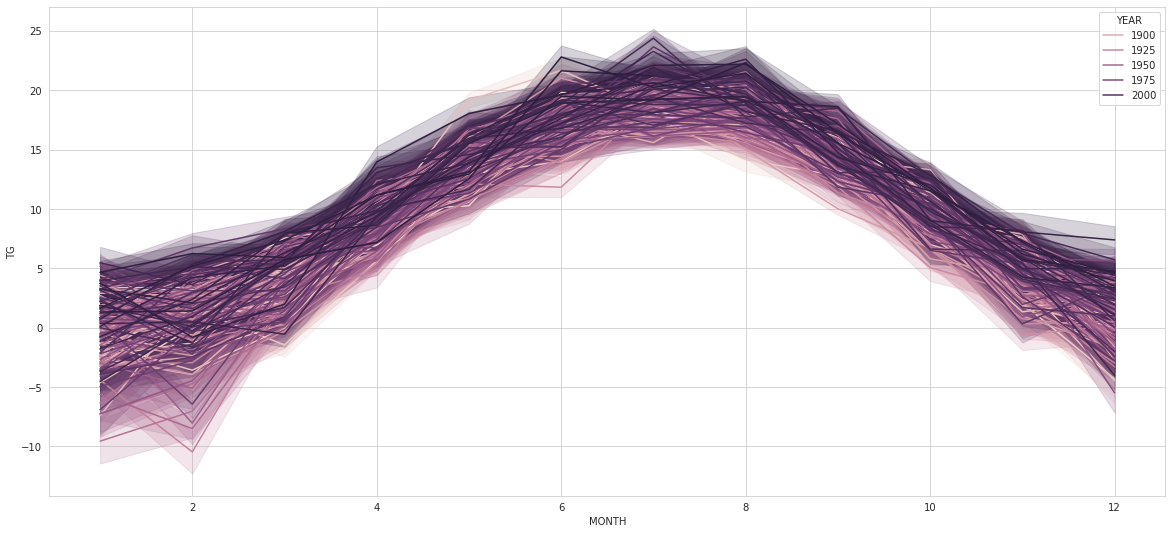

In [15]:
# lineplot to show outliers
plt.subplots(figsize= (20,9))
sns.lineplot(x='MONTH', y='TG', hue='YEAR', data=df_train)

## 3. Build a GIF

In [17]:
# create animation which shows the monthly temperature per year and the average temperatures of the current 
# year, the max average temperature at all and the average temperature at the start of the observations (1876)
run_code = True
if run_code:
    # create directory for the plots:
    path = '../../data/lineplots/'
    if not os.path.exists(path):
        os.mkdir(path)
    # create a list of subsets. one subset for each year between 1960 and 2015
    temp_start = mean_year = df_train['TG'].loc[df_train['YEAR'] == 1876].mean()
    temp_max = mean_year = df_train['TG'].loc[df_train['YEAR'] == 1876].mean()
    for year in range(1876, 2021):
        # set the axis to contain all min and max values
        plt.axis((1, 12, -15, 25))
        plt.title(str(year))
        # get the mean temperature of the year. 
        temp_year = df_train['TG'].loc[df_train['YEAR'] == year].mean()
        # if higher than current max, assign new max.
        if temp_year > temp_max:
            temp_max = temp_year
        # print mean temp year and max
        plt.plot([0, 12], [temp_year, temp_year], color="green")
        plt.plot([0, 12], [temp_max, temp_max], color="red")
        plt.plot([0, 12], [temp_start, temp_start], color="blue")
        # plot the image 
        df_subset = df_train.loc[df_train['YEAR'] == year]
        sns.lineplot(x='MONTH', y='TG', hue='YEAR', data=df_subset, alpha=0.6)
        # save each image as png-file
        filename = '../../data/lineplots/temp_' + str(year) + '.png'
        plt.savefig(filename, dpi= 200)
        plt.close()

In [19]:
# create the GIF from the seperate year files
run_code = True
if run_code:
    images = []
    for year in range(1876, 2021):
        filename = '{}temp_{}.png'.format(path, year)
        images.append(imageio.imread(filename))
    imageio.mimsave('output.gif', images, fps=10)

## 4. Build models to predict the temperature

### 4.1 model the trend of the timeseries

#### 4.1.1. examine the trend of the timeseries

<AxesSubplot:xlabel='YEAR', ylabel='TG'>

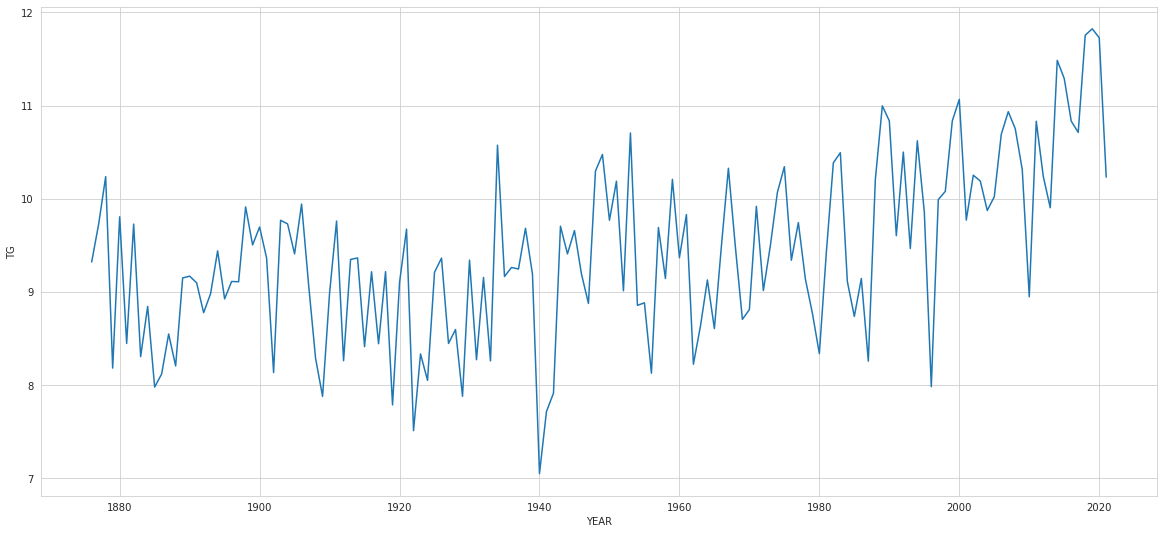

In [23]:
# plot the average temperature by year
plt.subplots(figsize= (20,9))
sns.lineplot(data=df_train.groupby('YEAR')['TG'].mean().to_frame(), x='YEAR', y='TG')


<AxesSubplot:>

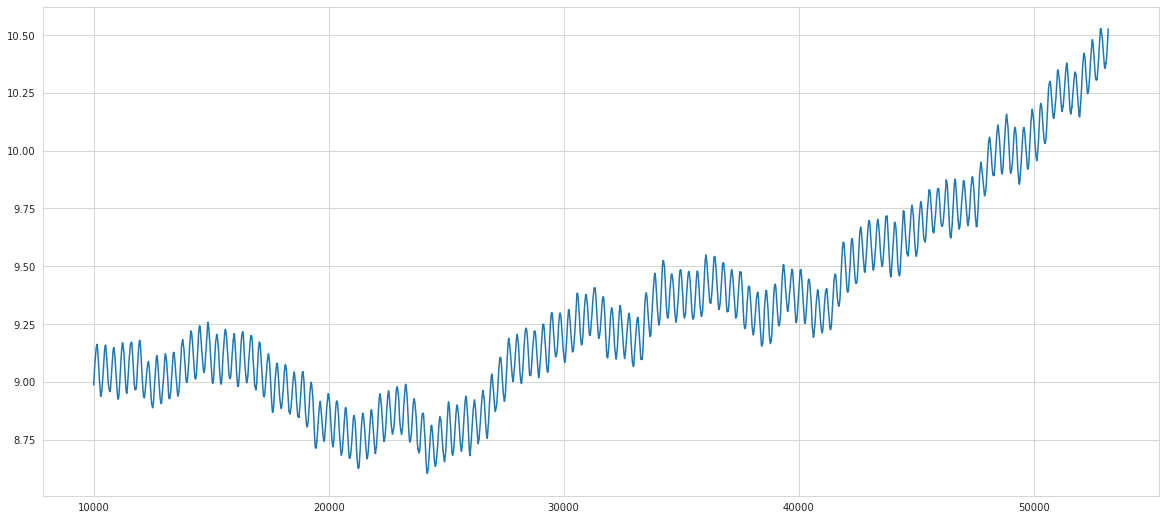

In [57]:
# plot the rolling 10000 days mean to see the more clean trend
plt.subplots(figsize= (20,9))
df_train['TG'].rolling(10000).mean().plot()

#### 4.2.2. create the trend curve

In [28]:
# create the timesteps
df_train['timestamp'] = list(range(df_train.shape[0]))
X_train = df_train[['timestamp']]
y_train = df_train['TG']

/tmp/ipykernel_17356/1411509642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['timestamp'] = list(range(df_train.shape[0]))


In [29]:
# create the polynomial features of degree 5 (as the curve looks like having 4 local optima)
poly = PolynomialFeatures(degree=5)
poly_train = poly.fit_transform(X_train)
X_train = pd.DataFrame(data=poly_train, index=X_train.index, columns=poly.get_feature_names_out())
X_train.drop(columns=['1'], inplace=True)
X_train.head(4)


,timestamp,timestamp^2,timestamp^3,timestamp^4,timestamp^5
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,2.0,4.0,8.0,16.0,32.0
3,3.0,9.0,27.0,81.0,243.0


In [30]:
# train a linear regression model
mod_trend = LinearRegression()
mod_trend.fit(X_train, y_train)
# add the predictions to the original train data
df_train = pd.concat([df_train, X_train], axis=1)
df_train['trend'] = mod_trend.predict(X_train)
mod_trend.coef_

array([ 9.84961023e-23,  2.21056802e-18,  2.90077339e-14, -1.14126957e-18,
        1.70327952e-23])

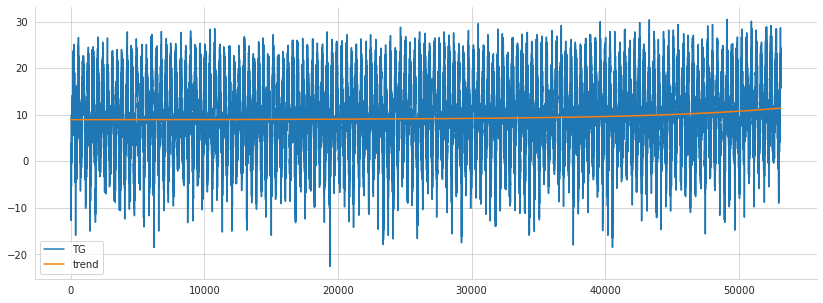

In [31]:
# plot the trendline
df_train[['TG','trend']].plot(figsize=(14,5),legend=True)
sns.despine()

<AxesSubplot:>

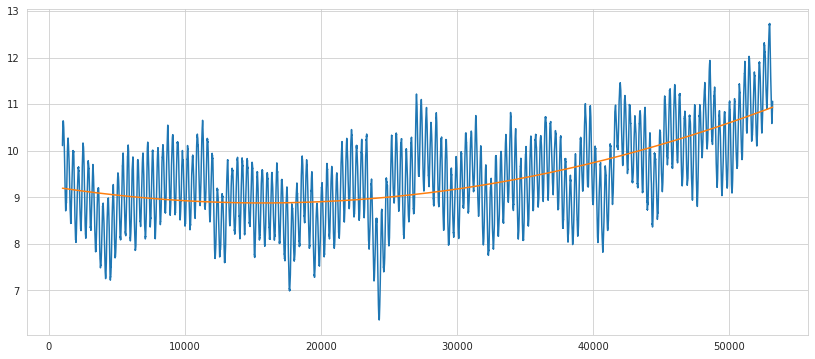

In [62]:
# plot the rolling means of the temperature and the prediction
df_train['TG'].rolling(1000).mean().plot()
df_train['trend'].rolling(1000).mean().plot()

### 4.2 model the seasonality of the timeseries

In [32]:
# add months to get and get dummies for it
df_train['month'] = df_train['DATETIME'].dt.month
df_month_dummies = pd.get_dummies(
    df_train['month'], 
    prefix='month', 
    drop_first=True
).set_index(df_train.index)
# add the one hot encoded months to the train dataframe
df_train = pd.concat([df_train, df_month_dummies], axis = 1)
# calculate the detrended values by subtracting the predicted trend from the temperature
df_train['detrended'] = df_train['TG'] - df_train['trend']
df_train.head(5)

,SOUID,DATE,TG,Q_TG,DATETIME,MONTH,QUARTER,YEAR,timestamp,timestamp,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,detrended
0,127488,18760101,2.2,0,1876-01-01,1,1,1876,0,0.0,...,0,0,0,0,0,0,0,0,0,-6.741184
1,127488,18760102,2.5,0,1876-01-02,1,1,1876,1,1.0,...,0,0,0,0,0,0,0,0,0,-6.441184
2,127488,18760103,0.3,0,1876-01-03,1,1,1876,2,2.0,...,0,0,0,0,0,0,0,0,0,-8.641184
3,127488,18760104,-5.8,0,1876-01-04,1,1,1876,3,3.0,...,0,0,0,0,0,0,0,0,0,-14.741184
4,127488,18760105,-9.8,0,1876-01-05,1,1,1876,4,4.0,...,0,0,0,0,0,0,0,0,0,-18.741184


In [33]:
# x data is the one hot encoded months data and y is the detrended temperature
X_seasonality = df_train[df_train.columns[-12:-1]]
y_seasonality = df_train['detrended']
# fit a linear regression model
mod_saisonal = LinearRegression()
mod_saisonal.fit(X_seasonality, y_seasonality)
# predict the saisonal temperature values and add them to the trend value (to later calculate the remainder)
df_train['saisonal'] = mod_saisonal.predict(X_seasonality)
df_train['trend_saisonal'] = df_train['trend'] + df_train['saisonal']
mod_saisonal.coef_

array([ 0.95047526,  4.18458282,  8.85761288, 13.93899707, 17.32726097,
       19.02999402, 18.29889335, 14.49997024,  9.48886942,  4.57335287,
        1.35991886])

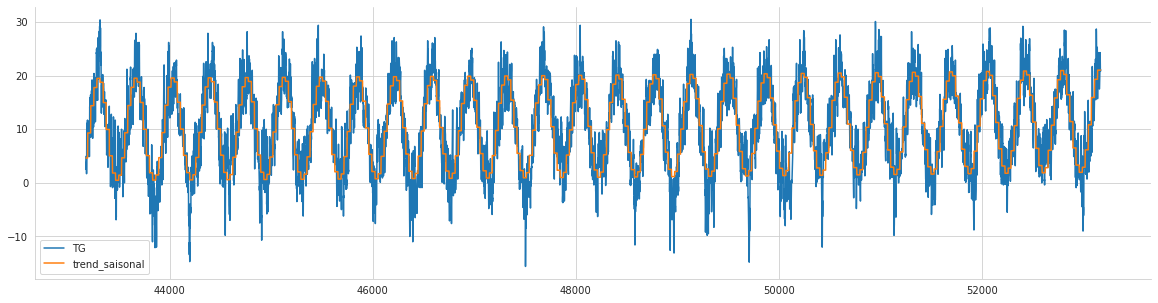

In [35]:
# plot the trend_and_saisonal line
df_train_plot = df_train[-10000:]
df_train_plot[['TG','trend_saisonal']].plot(figsize=(20,5),legend=True)
sns.despine()

<AxesSubplot:>

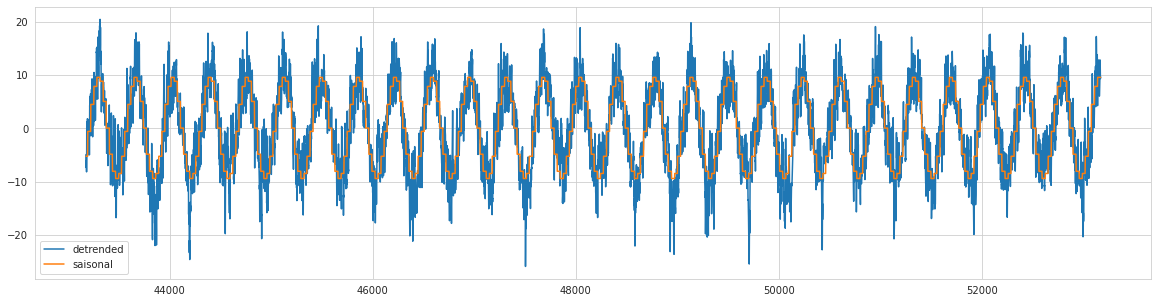

In [36]:
# plot the detrended and the saisonal line
df_train_plot[['detrended','saisonal']].plot(figsize=(20,5),legend=True)

### 4.3 predict the remainder

In [37]:
df_train[['TG', 'trend', 'trend_saisonal']].head(3)

,TG,trend,trend_saisonal
0,2.2,8.941184,-0.476272
1,2.5,8.941184,-0.476272
2,0.3,8.941184,-0.476272


<AxesSubplot:>

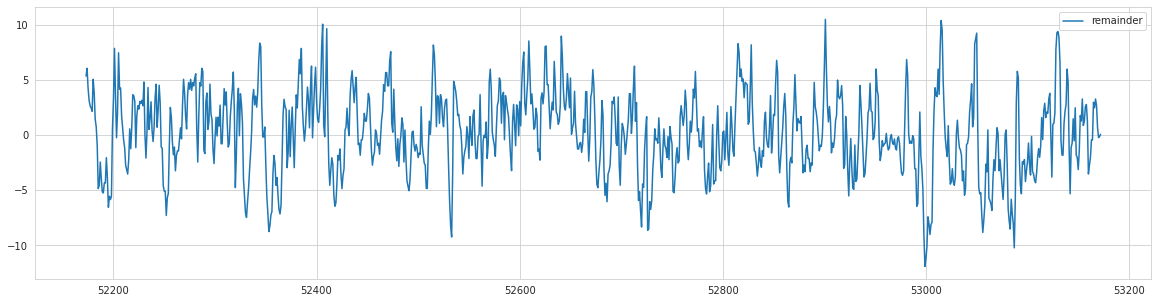

In [39]:
# calculate the remainder row (temperature - trend - saisonality)
df_train['remainder'] = df_train['TG'] - df_train['trend_saisonal']
df_train['remainder'][-1000:].plot(figsize=(20,5),legend=True)

In [64]:
# test the remainder for stationarity
print(adfuller(df_train['remainder']))

(-24.289630009455113, 0.0, 58, 53111, {'1%': -3.4304731311043515, '5%': -2.861594421489598, '10%': -2.566798966746799}, 239481.01454903773)


#### 4.3.1 create the timelags of the remainder

In [40]:
# maximum interval to consider
p = 3
lags = [i + 1 for i in range(p)]

# create forward remainder timelags by forwardshifting it up to p days
for lag in lags:
    column_name = 'lag' + str(lag)
    df_train[column_name] = df_train['remainder'].shift(lag)

# drop the NaN created by the shifting
df_train.dropna(inplace=True) 

/home/thorsten/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thorsten/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thorsten/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

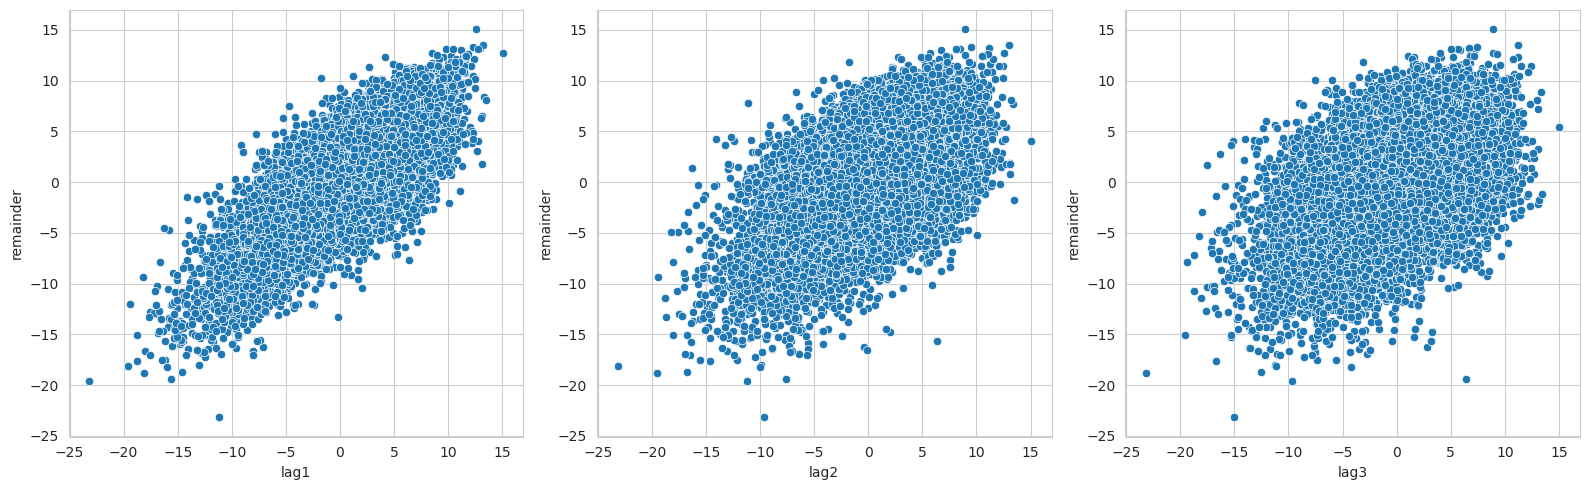

In [45]:
# plot scatterplots between the different timelagged remainder and the remainder
lag_columns = df_train.columns[-p:]
fig, axes = plt.subplots(nrows=1 , ncols=p, figsize=(16,5), dpi=100)
# gs = gridspec.GridSpec(1, p)

for i in range(p):
    sns.scatterplot(df_train[lag_columns[i]], df_train['remainder'],ax=axes[i])
    
plt.tight_layout()

#### 4.3.2 instantiate a model and predict the remainder

In [53]:
# feature (timelagged temperatures) and target (remainder) for autoregression model
X_remainder = df_train[lag_columns[:p]]
y_remainder = df_train['remainder']

In [54]:
# instantiate and fit a linear regression model
mod_ar = LinearRegression()
mod_ar.fit(X_remainder, y_remainder)
print(mod_ar.coef_, mod_ar.score(X_remainder, y_remainder))

[ 0.91923482 -0.19644758  0.06871484] 0.6521329442958266


<AxesSubplot:>

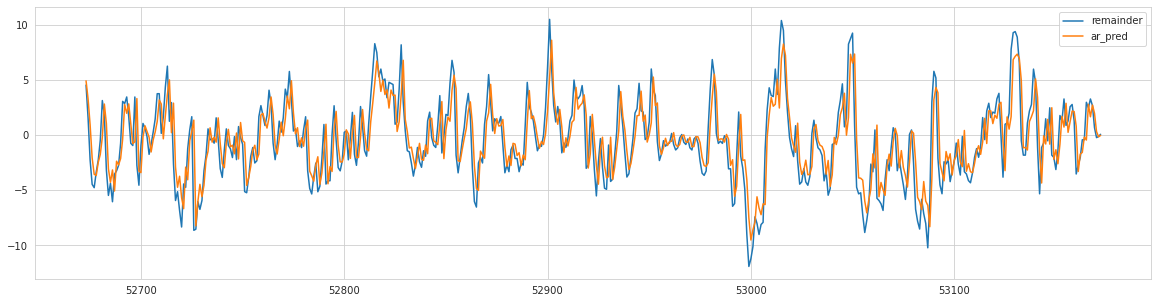

In [55]:
# plot the remainder and the corresponding prediction
df_train['ar_pred'] = mod_ar.predict(X_remainder)
df_train[['remainder','ar_pred']][-500:].plot(figsize=(20,5),legend=True)

#### 4.3.3. plot the autocorrelations and the partial autocorrelations

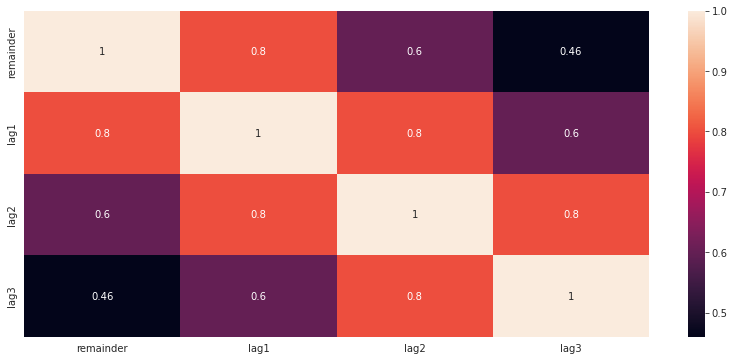

In [56]:
# plot a heatmap of the correlations of the remainder and the timelagged remainders
plt.rcParams['figure.figsize'] = (14,6)
sns.heatmap(round(df_train[['remainder', 'lag1', 'lag2', 'lag3']].corr(), 2), annot=True)
None

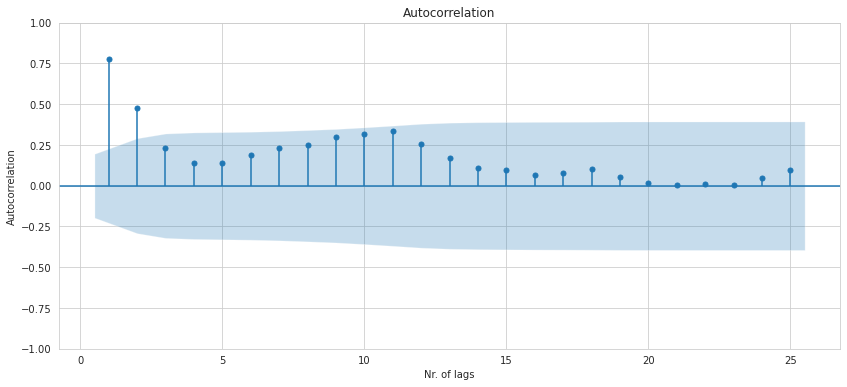

In [57]:
# plot the partial autocorrelations of the lagged remainders to define how many lags to use
plot_acf(df_train['remainder'][-100:],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
None


/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


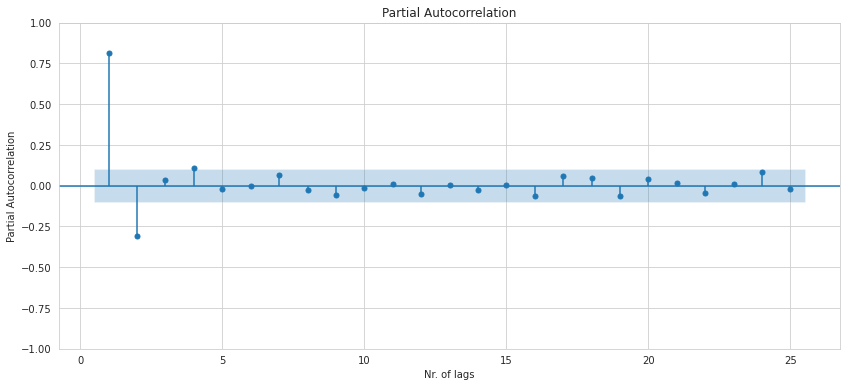

In [58]:
# plot partial autocorrelation function (direct correlation w/o indirect correlations in between lying timelags)
plot_pacf(df_train['remainder'][-365:],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None

### 4.4. Check the residual for remaining correlations

In [59]:
# calculate the residual
df_train['residuals_ar'] = df_train['remainder'] - df_train['ar_pred']

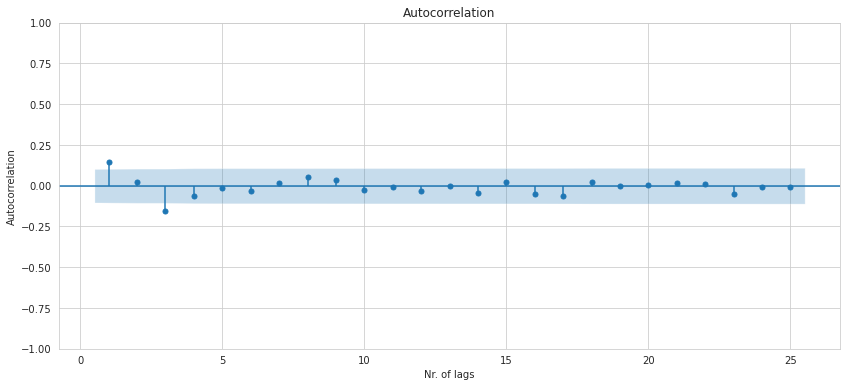

In [60]:
# plot autocorrelation function
plot_acf(df_train['residuals_ar'][-365:],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
None

/home/thorsten/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


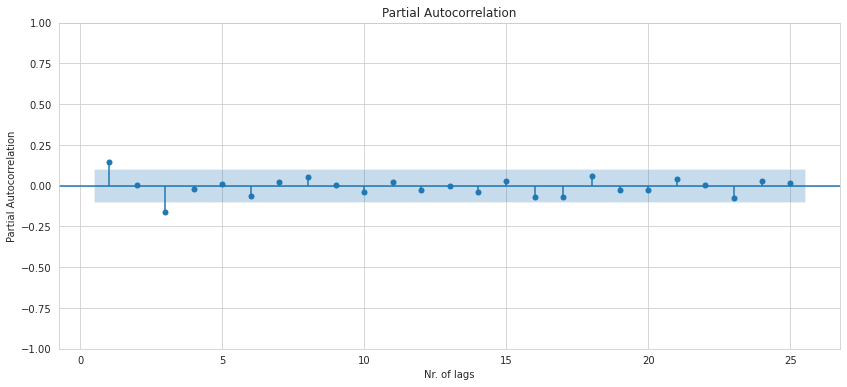

In [62]:
# plot the partial autocorrelations
plot_pacf(df_train['residuals_ar'][-365:],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
None